# Epeak_Eiso_cosmology.ipynb
We have searched for a $E_\text{peak}- E_\text{iso}$ fit in the [Epeak-Eiso_corelation.ipynb](https://github.com/joanalnu/oab-inaf/blob/main/Epeak_Eiso_correlation.ipynb) and computed $E_\text{iso}$ from respective fluences $S$ in dependency of cosmology in [Eiso_from_fluence.ipynb](https://github.com/joanalnu/oab-inaf/blob7main/Eiso_from_fluence.ipynb). In this notebook, we employ all that to constrain the cosmological parameters, searching for $E_\text{peak}-E_\text{iso}$ fit with less scatter (i.e. shorter point-fit distances), indicating the 'best cosmology'.

In [10]:
from calendar import day_abbr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jsonschema.benchmarks.const_vs_enum import value
from scipy.integrate import cumulative_trapezoid
from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm import tqdm
import itertools
#from codecarbon import EmissionsTracker as tracker
#tracker = EmissionsTracker()

In [2]:
# read data
df = pd.read_csv('table.csv')

Epeak = np.log10(df['Epeak'])
Epeak_err = np.log10(df['Epeak_err'])
z = df['z']
S = df['Fluence']  # ergs/cm2
S_err = df['Fluence_err']


# Convert H0 to cgs units: H0 [s^-1] = H0 [km/s/Mpc] * (km/Mpc to 1/s conversion)
# 1 Mpc = 3.086e24 cm, so H0_cgs = H0_kmsMpc * 1e5 / 3.086e24
H0_cgs = 70.0 * 1e5 / 3.086e24  # s^-1
c = 29979245800  # cm/s
Om_default = 0.3
Ode_default = 0.7
c = 2.99792458e10  # cm/s

def luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    Calculate luminosity distance for given redshift(s) and cosmological parameters.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    Ho : float
        Hubble constant in cgs units (s^-1)
    O_m : float
        Matter density parameter
    O_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Luminosity distance in cm
    """

    def luminosity_distance_single(z, Ho=Ho, O_m=O_m, O_DE=O_DE):
        def integrand(z_prime):
            return 1.0 / np.sqrt(O_m * (1 + z_prime)**3 + O_DE)

        # Create redshift sample array
        z_array = np.linspace(0, z, num=1000)

        # Evaluate integrand on array
        y_values = integrand(z_array)

        # Compute definite integral from 0 to z
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]

        # Compute luminosity distance
        return (c * (1 + z) / Ho) * integral

    # Handle scalar and array inputs
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])

def isotropic_equivalent_energy(redshift, fluence, H0=H0_cgs, Omega_m=Om_default, Omega_DE=Ode_default):
    """
    Calculate the isotropic equivalent energy.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    fluence : float or array
        Observed fluence (should be in erg/cm^2)
    H0 : float
        Hubble constant in cgs units (s^-1)
    Omega_m : float
        Matter density parameter
    Omega_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Log10 of isotropic equivalent energy
    """
    d_L = luminosity_distance(redshift, H0_cgs, Omega_m, Omega_DE)
    numerator = 4.0 * np.pi * (d_L ** 2) * fluence
    return np.log10(numerator / (1 + redshift))

def measure_distances(a, b, x, y):
    """
    Measures the distance between a point p = (x,y) and a line of best fit y=ax+b.
    :param p: coordinates of the point
    :param a: slope of the fit
    :param b: y-axis cut of the fit
    :return: scalar for the distance
    """
    # for the line point we use x0=0 and thus y0=b
    numerator = abs(a*x -y +b)
    denominator = np.sqrt(1 + (a ** 2))
    return numerator / denominator

def GoF(m,k,x,y):
    """
    Goodness of fit following the chi-squared formula
    :param m: slope
    :param k: y-axis cut
    :param x: x-values
    :param y: y-values
    :return: chi-squared value
    """
    model = m*x + k
    chi_squared = np.sum((y-model)**2)
    return chi_squared

In [3]:
#tracker.start()

# Define cosmological parameter grids
Om = np.linspace(0.0,2.0,15)
Ode = np.linspace(0.0,2.0,15)
k = np.linspace(-25.,-20.,25) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,25) # the slope must be positive

distances = np.zeros([len(Om), len(Ode), len(df['Eiso'])])
medians = np.zeros([len(Om), len(Ode)])

# this 3D array consist of a Om-Ode 2 grid and the depth corresponding to the distance for each data point (75)
for i, j in tqdm(itertools.product(range(len(Om)), range(len(Ode))), total=len(Om) * len(Ode), desc="Grid Search"):
#for i in range(len(Om)):
    #for j in range(len(Ode)):
        try:
            isotropic_model = isotropic_equivalent_energy(z,S,H0_cgs,Om[i],Ode[j])

            # check for NaN or inf values
            if np.any(~np.isfinite(isotropic_model)):
                distances[i,j,:] = np.inf # instead of NaN which creates problems when finding minimum with argmin
                medians[i,j] = np.inf
                print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, isotropic_model contains infinity or NaN')
                continue

            G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
            for mu in range(len(m)):
                for nu in range(len(k)):
                    G[mu,nu] = GoF(m[mu], k[nu], x=isotropic_model, y=Epeak)

            # extract best fit parameters
            best_fit = np.argmin(G)
            m_index, k_index = np.unravel_index(best_fit, G.shape)
            m_fit, k_fit = m[m_index], k[k_index]
            distances[i,j,:] = measure_distances(m_fit, k_fit, isotropic_model, Epeak)

            #average = np.sum(distances[i,j,:])/len(distances[i,j,:])
            medians[i,j] = np.sum(distances[i,j,:])/len(distances[i,j,:])
            #(mu, sigma) = norm.fit(d[i,j,:]) # gaussian of best fit using scipy
            #x_data = np.linspace(np.min(d[i,j,:]), np.max(d[i,j,:]),100)
            #ax[i,j].plot(x_data, gaussian(x_data, mu, sigma), c='r')
            #ax[i,j].vlines(mu, 0, 20, colors='red', linestyles='--')

            #print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, m_fit={m_fit:.3f}, k_fit={k_fit:.3f}, median = {medians[i,j]:.3f}')
            fig, ax = plt.subplots(1,2)
            ax[0].scatter(isotropic_model, Epeak, s=1)
            ax[0].plot(isotropic_model, m_fit*isotropic_model + k_fit, c='r', label=f'fit: m_fit={m_fit:.3f}, k_fit={k_fit:.3f}')
            ax[0].set_xlabel(r'$E_\text{iso}$'); ax[0].set_ylabel(r'$E_\text{peak}$'); ax[0].legend()

            ax[1].hist(distances[i,j,:])
            ax[1].vlines(medians[i,j], 0, 14, colors='r', linestyles='dashed', label=f'median: {medians[i,j]:.3f}')
            ax[1].set_xlabel('data-fit distances'); ax[1].legend()

            plt.tight_layout()
            fig.savefig(f'./figures/Om{Om[i]:.3f}_Ode{Ode[j]:.3f}_{i}{j}.png')
            plt.close()

        except Exception as e:
            print(f'Error at Om={Om[i]:.3f}, Ode={Ode[j]:.3f}: {e}')
            distances[i,j,:] = np.inf # mark as invalid

np.save(f'{len(Om)}_{len(m)}_distances.npy', distances)

#tracker.stop()

Grid Search:   0%|          | 0/225 [00:00<?, ?it/s]/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_220/4131614698.py:42: RuntimeWarning: divide by zero encountered in divide
  return 1.0 / np.sqrt(O_m * (1 + z_prime)**3 + O_DE)


0 0	Om=0.000, Ode=0.000, isotropic_model contains infinity or NaN


Grid Search: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


Best fit: Om=0.143, Ode=1.286
Minimum average distance: 0.163


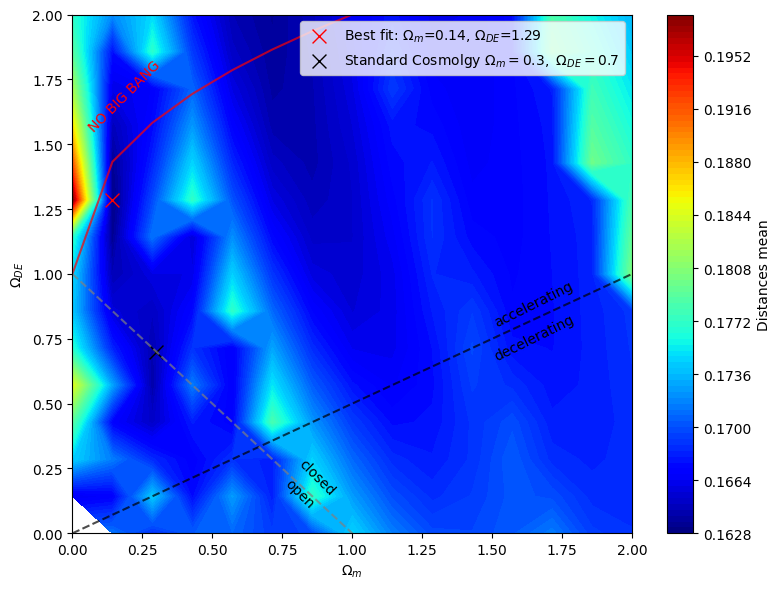

In [12]:
# now let's plot the (Om, Ode)mean surface
def create_mask(data, flat=True, no_big_bang=True):
    # Create a proper mask for unphysical regions
    # instead of a simple mask, the proper mask ensures that values aren't marked as NaN or 0, important for the argmin results
    mask = np.zeros_like(medians, dtype=bool)
    for i in range(len(Om)):
        for j in range(len(Ode)):
            if (Om[i]+Ode[j]>1.2 or # approx flat-universe region
                    Om[i]+Ode[j]<0.8):
                mask[i,j]=flat
            if (Ode[j]>Om[i]+1 or
                    Ode[j] >= Om[i]** (1/2.32) + 1.0 or # approx no big bang area
                    not np.isfinite(medians[i, j])):
                mask[i,j]=no_big_bang
            if data[i,j]==np.inf:
                mask[i,j]=True

    return np.ma.masked_where(mask,data)

def add_constraint_lines(plt):
    plt.plot(Om, 0.5*Om, linestyle='--', color='black', alpha=0.7)
    plt.annotate('accelerating', (1.5,0.80), rotation=26.35)
    plt.annotate('decelerating', (1.5,0.67), rotation=26.35)

    plt.plot(Om, Om**(1/2.32)+1, c='r', alpha=0.7)
    plt.annotate('NO BIG BANG', (0.05,1.55), rotation=45, color='red')

    plt.plot(Om, 1-Om, linestyle='--', color='gray', alpha=0.7)
    plt.annotate('open', (0.75,0.1), rotation=-45)
    plt.annotate('closed', (0.8,0.15), rotation=-45)
    return 0

masked_medians = create_mask(medians, flat=False, no_big_bang=False)

Om_index, Ode_index = np.unravel_index(np.argmin(masked_medians), masked_medians.shape)
Om_fit, Ode_fit = Om[Om_index], Ode[Ode_index]

print(f'Best fit: Om={Om_fit:.3f}, Ode={Ode_fit:.3f}')
print(f'Minimum average distance: {masked_medians[Om_index,Ode_index]:.3}')


# Plot
plt.figure(figsize=(8, 6))
im = plt.contourf(Om, Ode, masked_medians.T, cmap='jet', levels=100)
plt.colorbar(im, label='Distances mean')
plt.scatter(Om_fit, Ode_fit, c='red', marker='x', s=100, linewidth=1, label=fr'Best fit: $\Omega_m$={Om_fit:.2f}, $\Omega_{'{DE}'}$={Ode_fit:.2f}')
plt.scatter(0.3, 0.7, c='black', marker='x', s=100, linewidths=1, label=r'Standard Cosmolgy $\Omega_m = 0.3,\ \Omega_{DE} = 0.7$')

add_constraint_lines(plt.gca())
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')
plt.legend(loc='upper right')
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.tight_layout()

### Basically the same, but with more resolution

[codecarbon INFO @ 15:53:38] Codecarbon is taking the configuration from global file: /Users/joanalnu/.codecarbon.config
[codecarbon WARNING @ 15:53:38] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 15:53:38] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 15:53:38] [setup] RAM Tracking...
[codecarbon INFO @ 15:53:38] [setup] CPU Tracking...
[codecarbon WARNING @ 15:53:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 15:53:38] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 15:53:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:53:38] [setup] GPU Tracking...
[codecarbon INFO @ 15:53:38] No GPU found.
[codecarbon INFO @ 15:53:38] The below tracking methods have been set 

0 0	Om=0.000, Ode=0.000, isotropic_model contains infinity or NaN


Grid Search:   4%|▍         | 104/2500 [00:13<05:02,  7.91it/s][codecarbon INFO @ 15:53:52] Energy consumed for RAM : 0.000062 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 15:53:52] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 15:53:52] Energy consumed for All CPU : 0.000104 kWh
[codecarbon INFO @ 15:53:52] 0.000166 kWh of electricity used since the beginning.
Grid Search:   4%|▍         | 112/2500 [00:14<04:56,  8.05it/s][codecarbon INFO @ 15:53:53] Energy consumed for RAM : 0.000013 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 15:53:53] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 15:53:53] Energy consumed for All CPU : 0.000021 kWh
[codecarbon INFO @ 15:53:53] 0.000033 kWh of electricity used since the beginning.
Grid Search:   9%|▉         | 221/2500 [00:28<04:50,  7.85it/s][codecarbon INFO @ 15:54:07] Energy consumed for RAM : 0.000075 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 15:54:07] Delta

Best fit: Om=0.163, Ode=1.224
Minimum average distance: 0.163


0.00026130963556416346

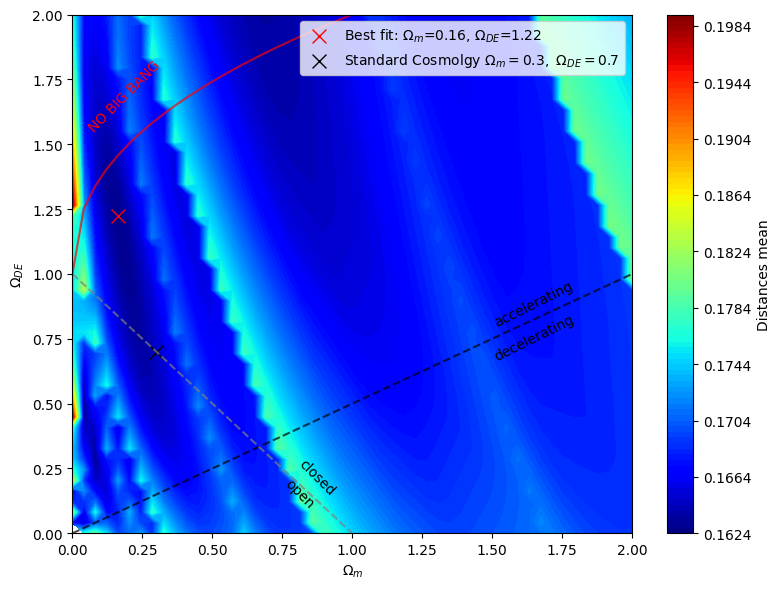

[codecarbon INFO @ 15:59:45] Energy consumed for RAM : 0.000356 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 15:59:45] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 15:59:45] Energy consumed for All CPU : 0.000594 kWh
[codecarbon INFO @ 15:59:45] 0.000950 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:00] Energy consumed for RAM : 0.000368 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 16:00:00] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 16:00:00] Energy consumed for All CPU : 0.000615 kWh
[codecarbon INFO @ 16:00:00] 0.000983 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:00:15] Energy consumed for RAM : 0.000381 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 16:00:15] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 16:00:15] Energy consumed for All CPU : 0.000635 kWh
[codecarbon INFO @ 16:00:15] 0.001016 kWh of ele

In [20]:
#tracker.start()

# Define cosmological parameter grids
Om = np.linspace(0.0,2.0,50)
Ode = np.linspace(0.0,2.0,50)
k = np.linspace(-25.,-20.,25) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,25) # the slope must be positive

distances = np.zeros([len(Om), len(Ode), len(df['Eiso'])])
medians = np.zeros([len(Om), len(Ode)])

# this 3D array consist of a Om-Ode 2 grid and the depth corresponding to the distance for each data point (75)
for i, j in tqdm(itertools.product(range(len(Om)), range(len(Ode))), total=len(Om) * len(Ode), desc="Grid Search"):
#for i in range(len(Om)):
    #for j in range(len(Ode)):
        try:
            isotropic_model = isotropic_equivalent_energy(z,S,H0_cgs,Om[i],Ode[j])

            # check for NaN or inf values
            if np.any(~np.isfinite(isotropic_model)):
                distances[i,j,:] = np.inf # instead of NaN which creates problems when finding minimum with argmin
                medians[i,j] = np.inf
                print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, isotropic_model contains infinity or NaN')
                continue

            G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
            for mu in range(len(m)):
                for nu in range(len(k)):
                    G[mu,nu] = GoF(m[mu], k[nu], x=isotropic_model, y=Epeak)

            # extract best fit parameters
            best_fit = np.argmin(G)
            m_index, k_index = np.unravel_index(best_fit, G.shape)
            m_fit, k_fit = m[m_index], k[k_index]
            distances[i,j,:] = measure_distances(m_fit, k_fit, isotropic_model, Epeak)

            #average = np.sum(distances[i,j,:])/len(distances[i,j,:])
            medians[i,j] = np.sum(distances[i,j,:])/len(distances[i,j,:])
            #(mu, sigma) = norm.fit(d[i,j,:]) # gaussian of best fit using scipy
            #x_data = np.linspace(np.min(d[i,j,:]), np.max(d[i,j,:]),100)
            #ax[i,j].plot(x_data, gaussian(x_data, mu, sigma), c='r')
            #ax[i,j].vlines(mu, 0, 20, colors='red', linestyles='--')

            #print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, m_fit={m_fit:.3f}, k_fit={k_fit:.3f}, median = {medians[i,j]:.3f}')
            fig, ax = plt.subplots(1,2)
            ax[0].scatter(isotropic_model, Epeak, s=1)
            ax[0].plot(isotropic_model, m_fit*isotropic_model + k_fit, c='r', label=f'fit: m_fit={m_fit:.3f}, k_fit={k_fit:.3f}')
            ax[0].set_xlabel(r'$E_\text{iso}$'); ax[0].set_ylabel(r'$E_\text{peak}$'); ax[0].legend()

            ax[1].hist(distances[i,j,:])
            ax[1].vlines(medians[i,j], 0, 14, colors='r', linestyles='dashed', label=f'median: {medians[i,j]:.3f}')
            ax[1].set_xlabel('data-fit distances'); ax[1].legend()

            plt.tight_layout()
            fig.savefig(f'./highres-figures/Om{Om[i]:.3f}_Ode{Ode[j]:.3f}_{i}{j}.png')
            plt.close()

        except Exception as e:
            print(f'Error at Om={Om[i]:.3f}, Ode={Ode[j]:.3f}: {e}')
            distances[i,j,:] = np.inf # mark as invalid

np.save(f'{len(Om)}_{len(m)}_distances.npy', distances)

masked_medians = create_mask(medians, flat=False, no_big_bang=False)

Om_index, Ode_index = np.unravel_index(np.argmin(masked_medians), masked_medians.shape)
Om_fit, Ode_fit = Om[Om_index], Ode[Ode_index]

print(f'Best fit: Om={Om_fit:.3f}, Ode={Ode_fit:.3f}')
print(f'Minimum average distance: {masked_medians[Om_index, Ode_index]:.3}')

# Plot
plt.figure(figsize=(8, 6))
im = plt.contourf(Om, Ode, masked_medians.T, cmap='jet', levels=100)
plt.colorbar(im, label='Distances mean')
plt.scatter(Om_fit, Ode_fit, c='red', marker='x', s=100, linewidth=1,
            label=fr'Best fit: $\Omega_m$={Om_fit:.2f}, $\Omega_{'{DE}'}$={Ode_fit:.2f}')
plt.scatter(0.3, 0.7, c='black', marker='x', s=100, linewidths=1,
            label=r'Standard Cosmolgy $\Omega_m = 0.3,\ \Omega_{DE} = 0.7$')

add_constraint_lines(plt.gca())
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')
plt.legend(loc='upper right')
plt.xlim(0.0, 2.0)
plt.ylim(0.0, 2.0)
plt.tight_layout()

#tracker.stop()

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, theta):
    """
    2D Gaussian function with rotation for cosmological parameter fitting

    Parameters:
    -----------
    xy : tuple of arrays
        (Om, Ode) coordinate meshgrids
    amplitude : float
        Peak amplitude (minimum chi-squared or distance value)
    x0, y0 : float
        Best-fit Om and Ode values
    sigma_x, sigma_y : float
        Standard deviations along principal axes
    theta : float
        Rotation angle in radians
    """
    x, y = xy

    # Rotation matrix coefficients
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    a = cos_theta**2 / (2*sigma_x**2) + sin_theta**2 / (2*sigma_y**2)
    b = -np.sin(2*theta) / (4*sigma_x**2) + np.sin(2*theta) / (4*sigma_y**2)
    c = sin_theta**2 / (2*sigma_x**2) + cos_theta**2 / (2*sigma_y**2)

    # For chi-squared like data, we want a "inverted" Gaussian (minimum at center)
    exponent = -(a*(x-x0)**2 + 2*b*(x-x0)*(y-y0) + c*(y-y0)**2)
    return amplitude * np.exp(exponent)

def fit_cosmology_gaussian(masked_medians, Om, Ode, invert_for_chisq=True):
    """
    Fit 2D Gaussian to cosmological chi-squared surface

    Parameters:
    -----------
    masked_medians : 2D array
        Distance/chi-squared matrix
    Om, Ode : 1D arrays
        Parameter coordinate arrays
    invert_for_chisq : bool
        If True, inverts the data (for chi-squared minimization)

    Returns:
    --------
    tuple : (fitted_parameters, fitted_surface, fit_success)
    """
    # Create meshgrid
    Om_grid, Ode_grid = np.meshgrid(Om, Ode)

    # For chi-squared data, we need to invert it to fit a Gaussian
    # (chi-squared has minimum at best fit, Gaussian has maximum)
    if invert_for_chisq:
        # Invert and normalize: make minimum -> maximum
        Z = np.max(masked_medians) - masked_medians
        Z = Z / np.sum(Z)  # Normalize
    else:
        Z = masked_medians / np.sum(masked_medians)

    if not np.isfinite(Z).all():
        raise ValueError("Z contains NaN or inf after preprocessing!")


    # Find best-fit location (maximum of inverted data)
    peak_idx = np.unravel_index(np.argmax(Z), Z.shape)
    Ode_peak_idx, Om_peak_idx = peak_idx  # Note: matrix indexing
    Om_best = Om[Om_peak_idx]
    Ode_best = Ode[Ode_peak_idx]

    # Initial parameter guesses
    amplitude_guess = np.max(Z)

    # Estimate widths from half-maximum contours
    half_max = amplitude_guess / 2

    # Om direction (sigma_x)
    Om_profile = Z[Ode_peak_idx, :]
    Om_indices = np.where(Om_profile >= half_max)[0]
    if len(Om_indices) > 1:
        sigma_Om_guess = (Om[Om_indices[-1]] - Om[Om_indices[0]]) / (2 * np.sqrt(2 * np.log(2)))
    else:
        sigma_Om_guess = (Om[-1] - Om[0]) / 8

    # Ode direction (sigma_y)
    Ode_profile = Z[:, Om_peak_idx]
    Ode_indices = np.where(Ode_profile >= half_max)[0]
    if len(Ode_indices) > 1:
        sigma_Ode_guess = (Ode[Ode_indices[-1]] - Ode[Ode_indices[0]]) / (2 * np.sqrt(2 * np.log(2)))
    else:
        sigma_Ode_guess = (Ode[-1] - Ode[0]) / 8

    # Initial guess for rotation
    theta_guess = 0.0

    initial_params = [amplitude_guess, Om_best, Ode_best, sigma_Om_guess, sigma_Ode_guess, theta_guess]

    print(f"Gaussian fitting initial guesses:")
    print(f"  Best fit: Ωₘ={Om_best:.3f}, ΩDE={Ode_best:.3f}")
    print(f"  Amplitude: {amplitude_guess:.6f}")
    print(f"  σ(Ωₘ): {sigma_Om_guess:.3f}")
    print(f"  σ(ΩDE): {sigma_Ode_guess:.3f}")

    #try:
    # Prepare data for fitting
    xy_data = np.vstack([Om_grid.ravel(), Ode_grid.ravel()])
    z_data = Z.ravel()

    # Set reasonable bounds
    lower_bounds = [0, Om[0], Ode[0], 0, 0, -np.pi]
    upper_bounds = [10**10, Om[-1], Ode[-1], Om[-1]-Om[0], Ode[-1]-Ode[0], np.pi]

    z_data = np.nan_to_num(z_data, nan=0.0, posinf=0.0, neginf=0.0) # ensuring it has not nans or infs
    fitted_params, covariance = curve_fit(
        gaussian_2d, xy_data, z_data,
        p0=initial_params,
        bounds=(lower_bounds, upper_bounds),
        maxfev=10000
    )

    # Generate fitted surface
    fitted_surface = gaussian_2d(xy_data, *fitted_params).reshape(Z.shape)

    # Calculate fit quality
    r_squared = 1 - np.sum((z_data - fitted_surface.ravel())**2) / np.sum((z_data - np.mean(z_data))**2)

    print(f"\nGaussian fit results:")
    print(f"  Fitted center: Ωₘ={fitted_params[1]:.3f}, ΩDE={fitted_params[2]:.3f}")
    print(f"  Fitted σ(Ωₘ): {fitted_params[3]:.3f}")
    print(f"  Fitted σ(ΩDE): {fitted_params[4]:.3f}")
    print(f"  Rotation angle: {fitted_params[5]:.3f} rad ({np.degrees(fitted_params[5]):.1f}°)")
    print(f"  R² fit quality: {r_squared:.4f}")

    return fitted_params, fitted_surface, True

    #except Exception as e:
    #    print(f"Gaussian fitting failed: {e}")
    #    return None, None, False

def calculate_cosmology_sigma_levels(fitted_params, sigmas=[1, 2, 3]):
    """
    Calculate sigma confidence levels for cosmological parameters
    """
    amplitude = fitted_params[0]

    # Calculate sigma levels
    sigma_levels = []
    for s in sigmas:
        level = amplitude * np.exp(-s**2 / 2)
        sigma_levels.append(level)

    # Sort in ascending order (matplotlib requirement)
    sigma_levels_sorted = sorted(sigma_levels)

    # Create mapping for labels
    level_to_sigma = {}
    sorted_sigmas = sorted(sigmas, reverse=True)
    for i, level in enumerate(sigma_levels_sorted):
        if i < len(sorted_sigmas):
            level_to_sigma[level] = f'{sorted_sigmas[i]}σ'

    return sigma_levels_sorted, level_to_sigma

def plot_cosmology_with_sigma_contours(masked_medians, Om, Ode, Om_fit, Ode_fit,
                                     sigmas=[1, 2, 3], add_constraint_lines=None,
                                     show_original=True):
    """
    Plot cosmological parameters with Gaussian-fitted sigma contours

    Parameters:
    -----------
    masked_medians : 2D array
        Distance/chi-squared matrix (shape should match meshgrid from Om, Ode)
    Om, Ode : 1D arrays
        Parameter coordinate arrays
    Om_fit, Ode_fit : float
        Best-fit values
    sigmas : list
        Sigma levels to plot
    add_constraint_lines : function, optional
        Function to add constraint lines to the plot
    show_original : bool
        Whether to show the original contour plot alongside
    """

    print("Fitting 2D Gaussian to cosmological likelihood surface...")

    # Fit Gaussian to the data
    fitted_params, fitted_surface, fit_success = fit_cosmology_gaussian(masked_medians, Om, Ode)

    if not fit_success:
        print("Gaussian fitting failed! Falling back to original contour plot.")
        # Plot original version as fallback
        plt.figure(figsize=(8, 6))
        im = plt.contourf(Om, Ode, masked_medians.T, cmap='jet', levels=100)
        plt.colorbar(im, label='Distances mean')
        plt.scatter(Om_fit, Ode_fit, c='red', marker='x', s=100, linewidth=1,
                   label=fr'Best fit: $\Omega_m$={Om_fit:.2f}, $\Omega_{{DE}}$={Ode_fit:.2f}')
        plt.scatter(0.3, 0.7, c='black', marker='x', s=100, linewidths=1,
                   label=r'Standard Cosmology $\Omega_m = 0.3,\ \Omega_{DE} = 0.7$')
        if add_constraint_lines:
            add_constraint_lines(plt.gca())
        plt.xlabel(r'$\Omega_m$')
        plt.ylabel(r'$\Omega_{DE}$')
        plt.legend(loc='upper right')
        plt.xlim(0.0, 2.0)
        plt.ylim(0.0, 2.0)
        plt.tight_layout()
        plt.show()
        return None

    # Calculate sigma levels
    sigma_levels, level_to_sigma = calculate_cosmology_sigma_levels(fitted_params, sigmas)

    # Create meshgrid for plotting
    Om_grid, Ode_grid = np.meshgrid(Om, Ode)

    if show_original:
        # Side-by-side comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Original chi-squared surface
        im1 = ax1.contourf(Om, Ode, masked_medians.T, cmap='jet', levels=100)
        plt.colorbar(im1, ax=ax1, label='Distances mean')
        ax1.scatter(Om_fit, Ode_fit, c='red', marker='x', s=100, linewidth=2,
                   label=fr'Best fit: $\Omega_m$={Om_fit:.2f}, $\Omega_{{DE}}$={Ode_fit:.2f}')
        ax1.scatter(0.3, 0.7, c='black', marker='x', s=100, linewidths=2,
                   label=r'Standard Cosmology $\Omega_m = 0.3,\ \Omega_{DE} = 0.7$')
        if add_constraint_lines:
            add_constraint_lines(ax1)
        ax1.set_xlabel(r'$\Omega_m$')
        ax1.set_ylabel(r'$\Omega_{DE}$')
        ax1.set_title('Original Chi-squared Surface')
        ax1.legend(loc='upper right')
        ax1.set_xlim(0.0, 2.0)
        ax1.set_ylim(0.0, 2.0)

        # Fitted Gaussian with sigma contours
        # Show the original data as background
        im2 = ax2.contourf(Om, Ode, masked_medians.T, cmap='jet', levels=100, alpha=0.3)

        # Overlay sigma contours
        colors = ['white', 'yellow', 'red']
        cs = ax2.contour(Om_grid, Ode_grid, fitted_surface, levels=sigma_levels,
                        colors=colors[:len(sigma_levels)], linewidths=3, linestyles='-')
        ax2.clabel(cs, fmt=level_to_sigma, inline=True, fontsize=12)#, fontweight='bold')

        # Add points
        ax2.scatter(fitted_params[1], fitted_params[2], c='red', marker='x', s=100, linewidth=2,
                   label=fr'Gaussian fit: $\Omega_m$={fitted_params[1]:.2f}, $\Omega_{{DE}}$={fitted_params[2]:.2f}')
        ax2.scatter(0.3, 0.7, c='black', marker='x', s=100, linewidths=2,
                   label=r'Standard Cosmology $\Omega_m = 0.3,\ \Omega_{DE} = 0.7$')

        if add_constraint_lines:
            add_constraint_lines(ax2)

        ax2.set_xlabel(r'$\Omega_m$')
        ax2.set_ylabel(r'$\Omega_{DE}$')
        ax2.set_title('Gaussian Fit with Sigma Contours')
        ax2.legend(loc='upper right')
        ax2.set_xlim(0.0, 2.0)
        ax2.set_ylim(0.0, 2.0)

    else:
        # Single plot with sigma contours
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Background chi-squared surface
        im = ax.contourf(Om, Ode, masked_medians.T, cmap='jet', levels=100, alpha=0.4)
        plt.colorbar(im, label='Distances mean')

        # Sigma contours
        colors = ['white', 'yellow', 'red']
        cs = ax.contour(Om_grid, Ode_grid, fitted_surface, levels=sigma_levels,
                       colors=colors[:len(sigma_levels)], linewidths=3, linestyles='-')
        ax.clabel(cs, fmt=level_to_sigma, inline=True, fontsize=12)#, fontweight='bold')

        # Add points
        ax.scatter(fitted_params[1], fitted_params[2], c='red', marker='x', s=100, linewidth=2,
                  label=fr'Gaussian fit: $\Omega_m$={fitted_params[1]:.2f}, $\Omega_{{DE}}$={fitted_params[2]:.2f}')
        ax.scatter(0.3, 0.7, c='black', marker='x', s=100, linewidths=2,
                  label=r'Standard Cosmology $\Omega_m = 0.3,\ \Omega_{DE} = 0.7$')

        if add_constraint_lines:
            add_constraint_lines(ax)

        ax.set_xlabel(r'$\Omega_m$')
        ax.set_ylabel(r'$\Omega_{DE}$')
        ax.set_title('Cosmological Parameters with Gaussian Sigma Contours')
        ax.legend(loc='upper right')
        ax.set_xlim(0.0, 2.0)
        ax.set_ylim(0.0, 2.0)

    plt.tight_layout()
    plt.show()

    return fitted_params, sigma_levels

def plot_cosmology_simple_replacement(masked_medians, Om, Ode, Om_fit, Ode_fit,
                                    add_constraint_lines=None, sigmas=[1, 2, 3]):
    """
    Simple drop-in replacement for your original plotting code
    Just call this instead of your original plt.figure() block
    """
    return plot_cosmology_with_sigma_contours(
        masked_medians, Om, Ode, Om_fit, Ode_fit,
        sigmas=sigmas, add_constraint_lines=add_constraint_lines,
        show_original=False
    )

Best fit: Om=0.143, Ode=1.286
Minimum average distance: 0.163
Fitting 2D Gaussian to cosmological likelihood surface...
Gaussian fitting initial guesses:
  Best fit: Ωₘ=1.286, ΩDE=0.143
  Amplitude: 0.005522
  σ(Ωₘ): 0.849
  σ(ΩDE): 0.789

Gaussian fit results:
  Fitted center: Ωₘ=1.070, ΩDE=1.058
  Fitted σ(Ωₘ): 1.377
  Fitted σ(ΩDE): 2.000
  Rotation angle: 1.774 rad (101.6°)
  R² fit quality: 0.1986


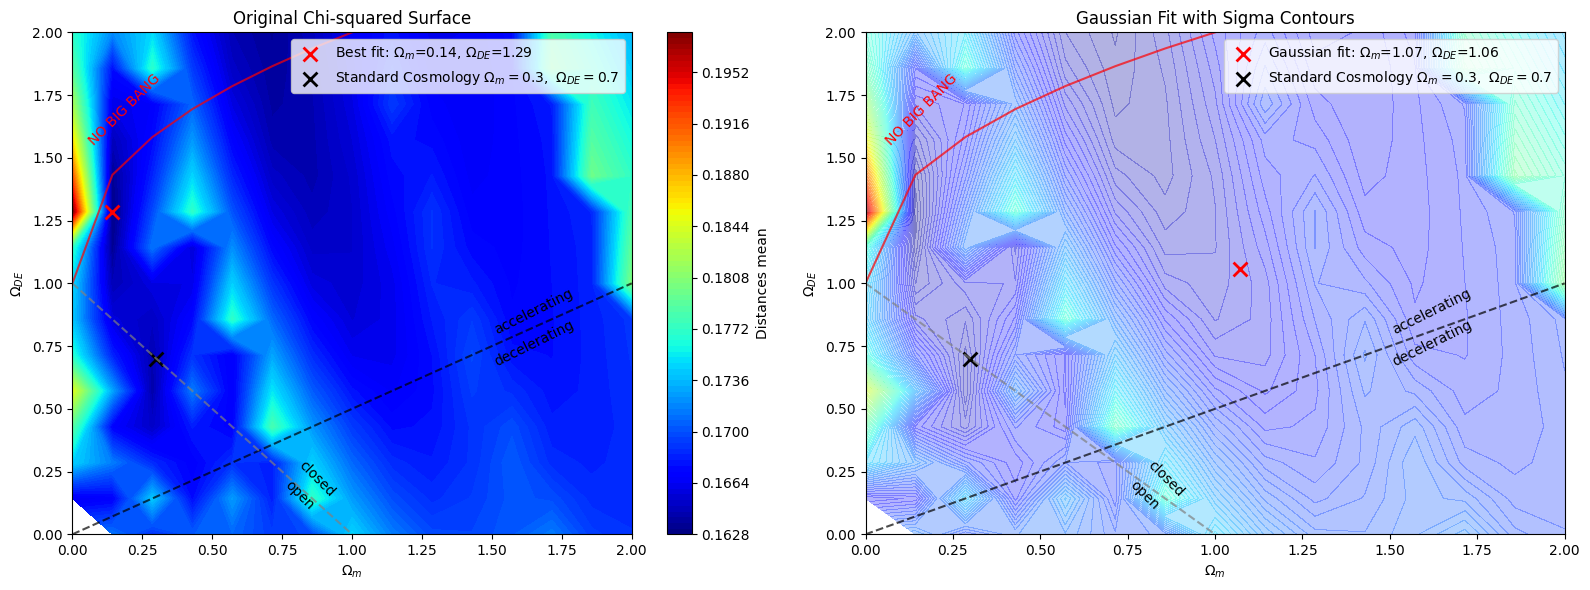

In [74]:
masked_medians = create_mask(medians, flat=False, no_big_bang=False)

Om_index, Ode_index = np.unravel_index(np.argmin(masked_medians), masked_medians.shape)
Om_fit, Ode_fit = Om[Om_index], Ode[Ode_index]

print(f'Best fit: Om={Om_fit:.3f}, Ode={Ode_fit:.3f}')
print(f'Minimum average distance: {masked_medians[Om_index, Ode_index]:.3}')

fitted_params, sigma_levels = plot_cosmology_with_sigma_contours(
    masked_medians, Om, Ode, Om_fit, Ode_fit,
    sigmas=[1, 2, 3],
    add_constraint_lines=add_constraint_lines,  # your existing function
    show_original=True  # Shows both original and fitted plots
)